In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [119]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as stats

from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler

from sklearn.manifold import TSNE

from sklearn.preprocessing import MinMaxScaler

import imblearn.under_sampling as under
import imblearn.over_sampling as over

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression

from sklearn.svm import OneClassSVM, SVC
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.neural_network import MLPClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB, ComplementNB, CategoricalNB

from tqdm import tqdm

In [3]:
df = pd.read_csv('/content/drive/MyDrive/FDS_Project/healthcare-dataset-stroke-data.csv')

In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


*We can drop column id as it a index column*

In [5]:
df = df.drop(['id'], axis=1)

# **EDA**

In [6]:
df.shape

(5110, 11)

In [7]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

**Analysis of Target Variable**

In [8]:
print(f'Count:\n{df["stroke"].value_counts()}\n')
print(f'Percentage:\n{round(df["stroke"].value_counts()*100/df.shape[0],2)}')

Count:
0    4861
1     249
Name: stroke, dtype: int64

Percentage:
0    95.13
1     4.87
Name: stroke, dtype: float64


*95% of the dataset contains data with label no stroke. This is a highly skewed dataset.*

**Analysis of Categorical Features**

In [9]:
print(f'Unique values in gender: {df["gender"].unique()}')
print(f'Unique values in hypertension: {df["hypertension"].unique()}')
print(f'Unique values in heart_disease: {df["heart_disease"].unique()}')
print(f'Unique values in ever_married: {df["ever_married"].unique()}')
print(f'Unique values in work_type: {df["work_type"].unique()}')
print(f'Unique values in Residence_type: {df["Residence_type"].unique()}')
print(f'Unique values in smoking_status: {df["smoking_status"].unique()}')

Unique values in gender: ['Male' 'Female' 'Other']
Unique values in hypertension: [0 1]
Unique values in heart_disease: [1 0]
Unique values in ever_married: ['Yes' 'No']
Unique values in work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Unique values in Residence_type: ['Urban' 'Rural']
Unique values in smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


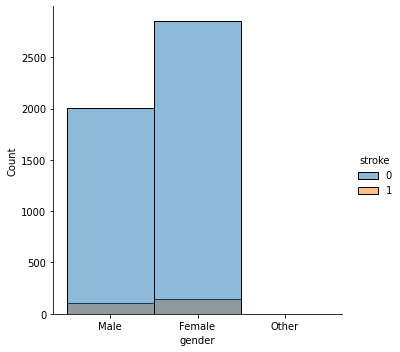

In [10]:
sns.displot(df,x="gender", hue="stroke")

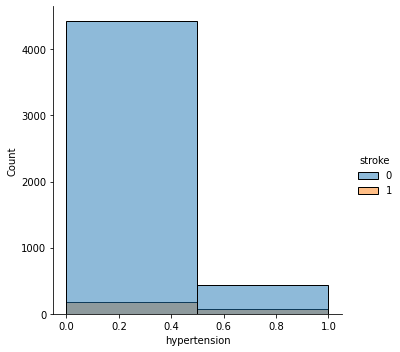

In [11]:
sns.displot(df,x="hypertension", hue="stroke", bins=2)

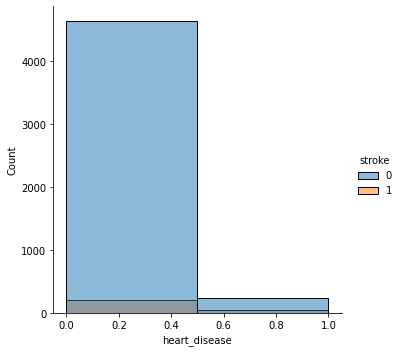

In [12]:
sns.displot(df,x="heart_disease", hue="stroke", bins=2)

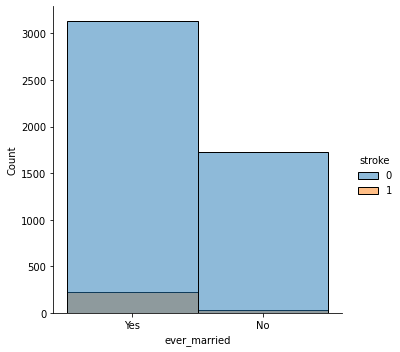

In [13]:
sns.displot(df,x="ever_married", hue="stroke")

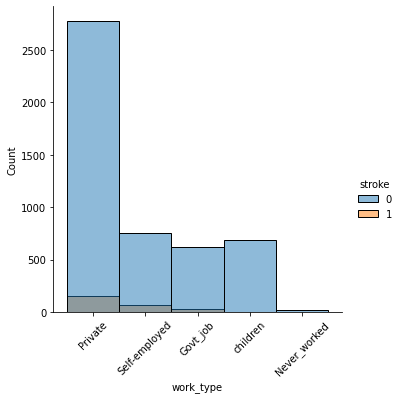

In [14]:
sns.displot(df,x="work_type", hue="stroke").set_xticklabels(rotation=45)

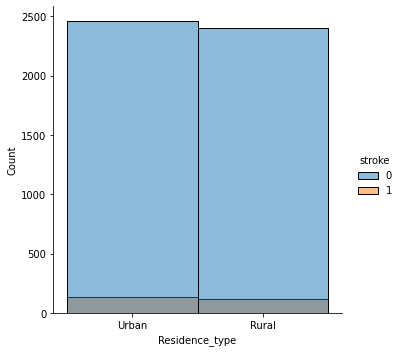

In [15]:
sns.displot(df,x="Residence_type", hue="stroke")

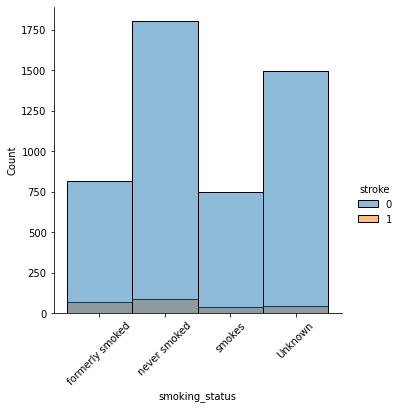

In [16]:
sns.displot(df,x="smoking_status", hue="stroke").set_xticklabels(rotation=45)

In [17]:
for column in ["gender","hypertension","heart_disease","ever_married","work_type","Residence_type","smoking_status"]:
  print(f'Percentage distribution for {column}:\n{round(df.groupby("stroke")[column].value_counts()*100/df.groupby("stroke")[column].count(),2)}')

Percentage distribution for gender:
stroke  gender
0       Female    58.69
        Male      41.29
        Other      0.02
1       Female    56.63
        Male      43.37
Name: gender, dtype: float64
Percentage distribution for hypertension:
stroke  hypertension
0       0               91.11
        1                8.89
1       0               73.49
        1               26.51
Name: hypertension, dtype: float64
Percentage distribution for heart_disease:
stroke  heart_disease
0       0                95.29
        1                 4.71
1       0                81.12
        1                18.88
Name: heart_disease, dtype: float64
Percentage distribution for ever_married:
stroke  ever_married
0       Yes             64.45
        No              35.55
1       Yes             88.35
        No              11.65
Name: ever_married, dtype: float64
Percentage distribution for work_type:
stroke  work_type    
0       Private          57.11
        Self-employed    15.51
        children

**Analysis of Continuous Features**

In [18]:
df[["age","avg_glucose_level","bmi"]].describe()

,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,4909.000000
mean,43.226614,106.147677,28.893237
std,22.612647,45.283560,7.854067
min,0.080000,55.120000,10.300000
25%,25.000000,77.245000,23.500000
50%,45.000000,91.885000,28.100000
75%,61.000000,114.090000,33.100000
max,82.000000,271.740000,97.600000


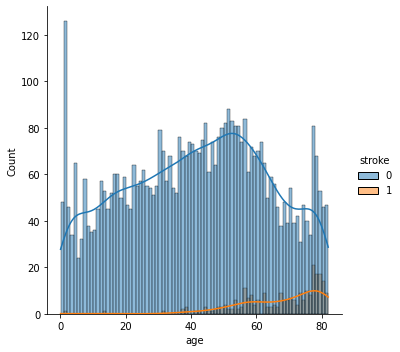

In [19]:
sns.displot(df, x="age", hue="stroke", kde=True, bins=82)

In [20]:
prob_after_40 = round(df.loc[((df["age"]>=40) & (df["stroke"]==1))].shape[0]*100/df.loc[(df["stroke"]==1)].shape[0],2)
print(f'Probability of stroke after age of 40: {prob_after_40}%')

Probability of stroke after age of 40: 96.79%


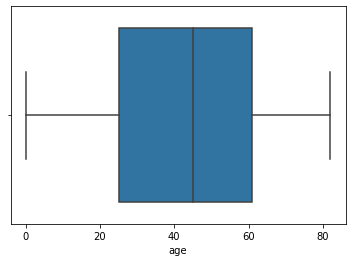

In [21]:
sns.boxplot(x=df["age"])

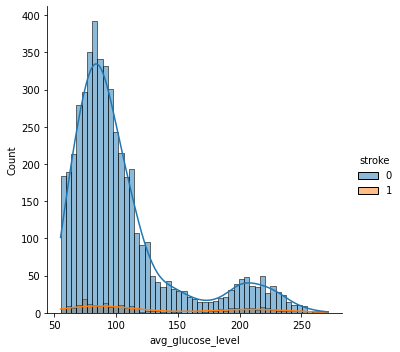

In [22]:
sns.displot(df, x="avg_glucose_level", hue="stroke", kde=True)

Creating 'Age Category' to group 'age' feature

In [23]:
df["age_category"] = pd.cut(df['age'],bins=[0,40,99],labels=[0,1])
df.groupby("age_category")['avg_glucose_level'].describe()

,count,mean,std,min,25%,50%,75%,max
age_category,,,,,,,,
0,2244.0,95.664256,30.948486,55.12,75.5225,88.925,107.7025,256.74
1,2866.0,114.355911,52.472671,55.22,78.6575,94.765,127.2700,271.74


In [24]:
prob_abnormal_glucose = round(df.loc[(((df["avg_glucose_level"]<90) | (df["avg_glucose_level"]>=150)) & (df["stroke"]==1))].shape[0]*100/df.loc[(df["stroke"]==1)].shape[0],2)
print(f'Probability of stroke if glucose levels are abnormal (below 90 or above 150): {prob_abnormal_glucose}%')

Probability of stroke if glucose levels are abnormal (below 90 or above 150): 71.49%


In [25]:
prob_abnormal_glucose = round(df.loc[(((df["avg_glucose_level"]<90) | (df["avg_glucose_level"]>=150)) & (df["stroke"]==1))].shape[0]*100/df.loc[((df["avg_glucose_level"]<90) | (df["avg_glucose_level"]>=150))].shape[0],2)
print(f'Probability of stroke if glucose levels are abnormal (below 90 or above 150): {prob_abnormal_glucose}%')

Probability of stroke if glucose levels are abnormal (below 90 or above 150): 5.68%


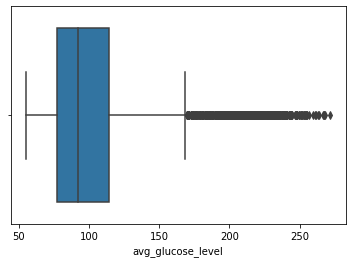

In [26]:
sns.boxplot(x=df["avg_glucose_level"])

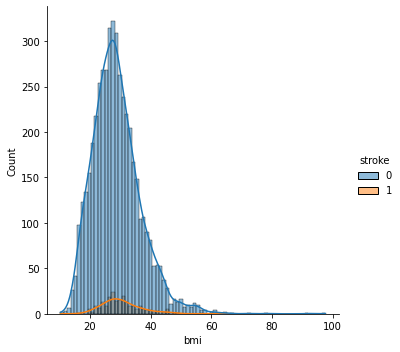

In [27]:
sns.displot(df, x="bmi", hue="stroke", kde=True)

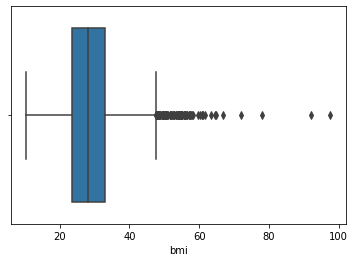

In [28]:
sns.boxplot(x=df["bmi"])

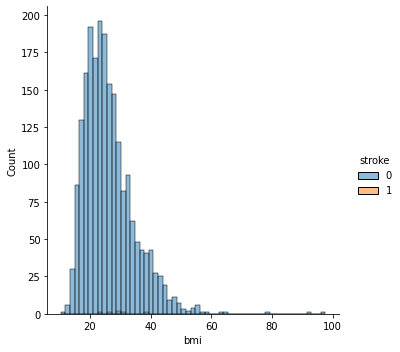

In [29]:
sns.displot(df.loc[(df["age"]<40)], x='bmi', hue='stroke')

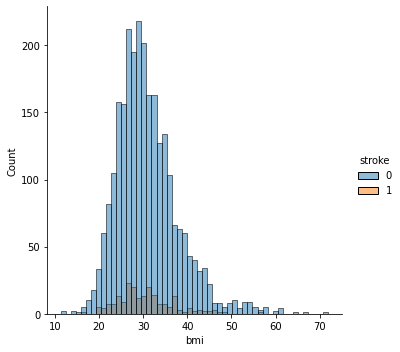

In [30]:
sns.displot(df.loc[(df["age"]>=40)], x='bmi', hue='stroke')

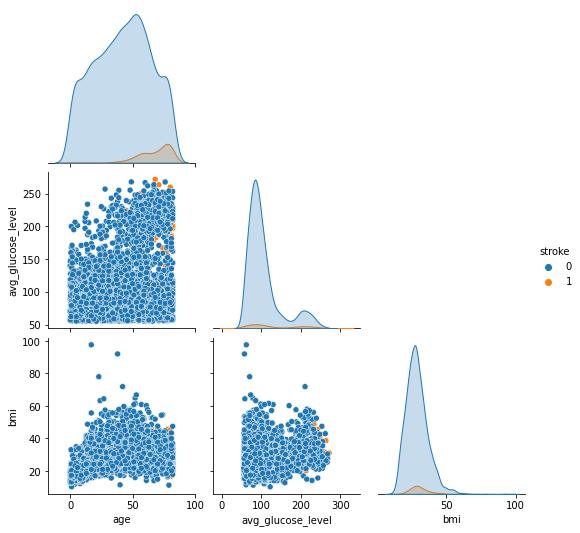

In [31]:
sns.pairplot(df[['age','avg_glucose_level','bmi','stroke']],hue='stroke', corner=True)

**Chi-Sqaure Test**

In [32]:
df_cleaned = pd.read_csv("/content/drive/MyDrive/FDS_Project/healthcare-dataset-stroke-data-clean.csv")
df_discrete = pd.DataFrame(data=df_cleaned[['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']])

In [33]:
# Restore categorical labels for chi-square test simplicity
df_discrete['gender'].loc[df_discrete['gender'] == 1] = 'Male'
df_discrete['gender'].loc[df_discrete['gender'] == 0] = 'Female'
df_discrete['ever_married'].loc[df_discrete['ever_married'] == 1] = 'Yes'
df_discrete['ever_married'].loc[df_discrete['ever_married'] == 0] = 'No'
df_discrete['hypertension'].loc[df_discrete['hypertension'] == 1] = 'Yes'
df_discrete['hypertension'].loc[df_discrete['hypertension'] == 0] = 'No'
df_discrete['heart_disease'].loc[df_discrete['heart_disease'] == 1] = 'Yes'
df_discrete['heart_disease'].loc[df_discrete['heart_disease'] == 0] = 'No'
df_discrete['work_type'].loc[df_discrete['work_type'] == 0] = 'Govt_job'
df_discrete['work_type'].loc[df_discrete['work_type'] == 1] = 'Never_worked'
df_discrete['work_type'].loc[df_discrete['work_type'] == 2] = 'Private'
df_discrete['work_type'].loc[df_discrete['work_type'] == 3] = 'Self-Employed'
df_discrete['work_type'].loc[df_discrete['work_type'] == 4] = 'children'
df_discrete['Residence_type'].loc[df_discrete['Residence_type'] == 0] = 'Rural'
df_discrete['Residence_type'].loc[df_discrete['Residence_type'] == 1] = 'Urban'
df_discrete['smoking_status'].loc[df_discrete['smoking_status'] == 0] = 'Unknown'
df_discrete['smoking_status'].loc[df_discrete['smoking_status'] == 1] = 'formerly smoked'
df_discrete['smoking_status'].loc[df_discrete['smoking_status'] == 2] = 'never smoked'
df_discrete['smoking_status'].loc[df_discrete['smoking_status'] == 3] = 'smokes'


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [34]:
# Run chi-square test on all bi-variate combinations of the discrete features
discrete_feats = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
         'Residence_type', 'smoking_status']
p_dict = {}

for L in range(0, len(discrete_feats)+1):
    for subset in itertools.combinations(discrete_feats, L):
        if len(subset) == 2:
            #Create contingency table and chi-square diagram
            contingency = pd.crosstab([df_discrete[subset[0]]], columns=[df_discrete[subset[1]]])
            stat, p, dof, expected = stats.chi2_contingency(contingency)
            new_pair = {subset:p}
            p_dict.update(new_pair)
            if p <= 0.05:
              print('\n',contingency)
              print("stat: ",stat)
              print("p: ",p)
              print("dof: ",dof)
              print("expected values: \n",expected)
              print("--------------------SIGNIFICANT--------------------")


 heart_disease    No  Yes
gender                  
Female         2881  113
Male           1952  163
stat:  36.743861733898285
p:  1.3471411533574369e-09
dof:  1
expected values: 
 [[2832.25719319  161.74280681]
 [2000.74280681  114.25719319]]
--------------------SIGNIFICANT--------------------

 ever_married   No   Yes
gender                 
Female        993  2001
Male          763  1352
stat:  4.522661198472507
p:  0.0334487647282252
dof:  1
expected values: 
 [[1029.05930711 1964.94069289]
 [ 726.94069289 1388.05930711]]
--------------------SIGNIFICANT--------------------

 work_type  Govt_job  Never_worked  Private  Self-Employed  children
gender                                                             
Female          399            11     1754            504       326
Male            258            11     1170            315       361
stat:  42.32035973379493
p:  1.431607380960033e-08
dof:  4
expected values: 
 [[ 385.01820317   12.89254257 1713.53611274  479.95419847  402.

In [35]:
p_dict = dict(sorted(p_dict.items(), key=lambda item: item[1]))
print("The below features have a statistically significant relationships")
print("(Note: statistical significance is determined by a p-value < 5%):\n")

for key, value in p_dict.items():
    if value < 0.05:
        print(key, value)

The below features have a statistically significant relationships
(Note: statistical significance is determined by a p-value < 5%):

('ever_married', 'work_type') 0.0
('work_type', 'smoking_status') 3.396344993475793e-290
('ever_married', 'smoking_status') 8.54686655490199e-130
('hypertension', 'ever_married') 1.5037858711857736e-31
('hypertension', 'work_type') 3.046403906045501e-28
('hypertension', 'smoking_status') 2.1899948949010706e-22
('heart_disease', 'ever_married') 4.427770773371616e-16
('heart_disease', 'work_type') 1.6233618322023935e-14
('hypertension', 'heart_disease') 2.2386283017948103e-14
('gender', 'smoking_status') 2.2731242721573073e-11
('heart_disease', 'smoking_status') 1.0510580705896141e-09
('gender', 'heart_disease') 1.3471411533574369e-09
('gender', 'work_type') 1.431607380960033e-08
('gender', 'ever_married') 0.0334487647282252


*Test for outliers: We observe that features avg_glucose_level and bmi have outliers*

In [36]:
quartile_1 = df[["age","avg_glucose_level","bmi"]].quantile(0.25)
quartile_3 = df[["age","avg_glucose_level","bmi"]].quantile(0.75)
inter_quartile_dist = quartile_3 - quartile_1

In [37]:
print(f'Number of Outliers:\n{((df[["age","avg_glucose_level","bmi"]] < (quartile_1 - 1.5 * inter_quartile_dist)) | (df[["age","avg_glucose_level","bmi"]] > (quartile_3 + 1.5 * inter_quartile_dist))).sum()}')
print(f'Percentage of Outliers:\n{round(((df[["age","avg_glucose_level","bmi"]] < (quartile_1 - 1.5 * inter_quartile_dist)) | (df[["age","avg_glucose_level","bmi"]] > (quartile_3 + 1.5 * inter_quartile_dist))).sum()*100/df.shape[0],2)}')

Number of Outliers:
age                    0
avg_glucose_level    627
bmi                  110
dtype: int64
Percentage of Outliers:
age                   0.00
avg_glucose_level    12.27
bmi                   2.15
dtype: float64


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f494f989bd0>

We see that the correlations between the continuous variables is NOT strong. There appears to be some correlation between age and bmi but it is weak.


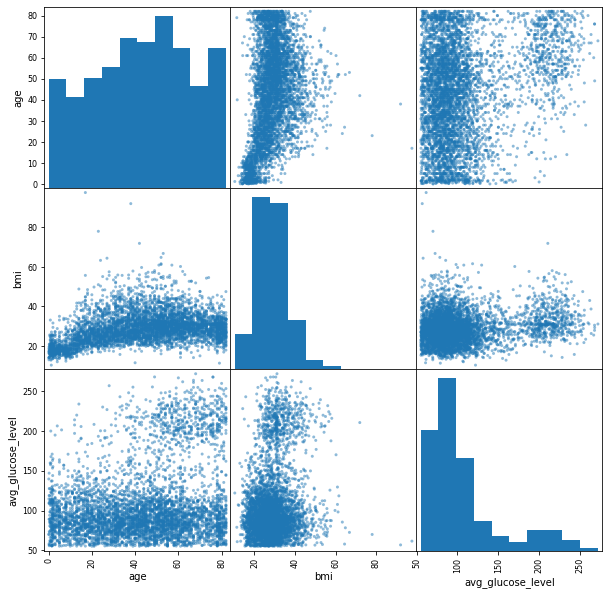

In [38]:
# Create new datafram for continuous features
df_continuous = pd.DataFrame(data=df_cleaned[['age', 'bmi', 'avg_glucose_level']])

# New configs for plotting readability
plt.rcParams['text.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['xtick.color'] = 'black'

# Create scatter matrix for continuous variables
scatter_matrix = pd.plotting.scatter_matrix(df_continuous,figsize=(10,10))
print(scatter_matrix)

print("\nWe see that the correlations between the continuous variables is NOT strong. There appears to be some correlation between age and bmi but it is weak.")


The heatmap confirms the findings from the scatter matrix above.


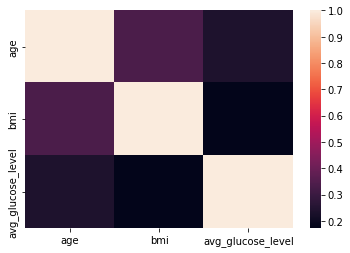

In [39]:
# Create correlation heatmap for continuous variables
sns.heatmap(df_continuous.corr(method="pearson"))

print("\nThe heatmap confirms the findings from the scatter matrix above.")

**Missing Values**

In [40]:
print(f'Number of missing values in dataset:\n{df.isna().sum()}')
print(f'Percentage of missing values in dataset:\n{round(df.isna().sum()*100/df.shape[0],2)}')

Number of missing values in dataset:
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
age_category           0
dtype: int64
Percentage of missing values in dataset:
gender               0.00
age                  0.00
hypertension         0.00
heart_disease        0.00
ever_married         0.00
work_type            0.00
Residence_type       0.00
avg_glucose_level    0.00
bmi                  3.93
smoking_status       0.00
stroke               0.00
age_category         0.00
dtype: float64


**Drop single row with gender = 2**

In [41]:
df = df.drop(df.index[df['gender']=='Other'].to_list())

**Handling Missing Values**

In [42]:
grouped_df = df.groupby(["age_category","gender"])["bmi"]
print('Age range for 0: 0-40, 1: 40+')
for key, item in grouped_df:
  print(f'Key: {key}\n{grouped_df. get_group(key).describe()}')

Age range for 0: 0-40, 1: 40+
Key: (0, 'Female')
count    1292.000000
mean       27.031889
std         8.381573
min        10.300000
25%        21.300000
50%        25.100000
75%        31.225000
max        78.000000
Name: bmi, dtype: float64
Key: (0, 'Male')
count    891.000000
mean      25.563861
std        7.907411
min       11.500000
25%       19.600000
50%       24.400000
75%       30.050000
max       97.600000
Name: bmi, dtype: float64
Key: (1, 'Female')
count    1605.000000
mean       30.702991
std         7.497808
min        11.300000
25%        25.500000
50%        29.500000
75%        34.500000
max        66.800000
Name: bmi, dtype: float64
Key: (1, 'Male')
count    1120.000000
mean       31.101429
std         6.062572
min        14.200000
25%        27.100000
50%        30.150000
75%        34.200000
max        71.900000
Name: bmi, dtype: float64


In [43]:
df["bmi"] = df.groupby(["age_category","gender"])["bmi"].transform(lambda x: x.fillna(x.mean()))

In [44]:
df = df.drop(["age_category"], axis=1)

In [45]:
df[["bmi"]].describe()

,bmi
count,5109.000000
mean,28.918649
std,7.711340
min,10.300000
25%,23.800000
50%,28.200000
75%,32.800000
max,97.600000


**Mapping categorical values to integer**

In [46]:
categories = ["gender","ever_married","work_type","Residence_type","smoking_status"]
for category in categories:
  df[category] = df[category].astype('category').cat.codes

In [47]:
print(f'Unique values in gender: {df["gender"].unique()}')
print(f'Unique values in hypertension: {df["hypertension"].unique()}')
print(f'Unique values in heart_disease: {df["heart_disease"].unique()}')
print(f'Unique values in ever_married: {df["ever_married"].unique()}')
print(f'Unique values in work_type: {df["work_type"].unique()}')
print(f'Unique values in Residence_type: {df["Residence_type"].unique()}')
print(f'Unique values in smoking_status: {df["smoking_status"].unique()}')

Unique values in gender: [1 0]
Unique values in hypertension: [0 1]
Unique values in heart_disease: [1 0]
Unique values in ever_married: [1 0]
Unique values in work_type: [2 3 0 4 1]
Unique values in Residence_type: [1 0]
Unique values in smoking_status: [1 2 3 0]


In [48]:
clean_data_path = "/content/drive/MyDrive/FDS_Project/healthcare-dataset-stroke-data-clean.csv"
df.to_csv(clean_data_path, index=False)

**Variable Importance using SVM with 'linear' kernel and Decision Tree**



In [49]:
x = df.drop(["stroke"], axis=1)
y = df["stroke"]

In [50]:
model_dtree = DecisionTreeClassifier()
model_dtree.fit(x,y)

DecisionTreeClassifier()

<BarContainer object of 10 artists>

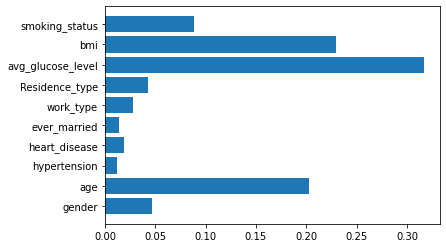

In [51]:
plt.barh(x.columns, model_dtree.feature_importances_)

In [52]:
feature_imp = {}
for itr, value in enumerate(model_dtree.feature_importances_):
  feature_imp[x.columns[itr]] = value
feature_imp = dict(sorted(feature_imp.items(), key=lambda item: item[1], reverse=True))
top_4 = []
for key, value in feature_imp.items():
  print(f'{key}: {value}')
  top_4.append(key)
top_4 = top_4[:4]

avg_glucose_level: 0.31674247682907136
bmi: 0.2294221603664761
age: 0.2030966151555643
smoking_status: 0.08832354284447776
gender: 0.046789105563423854
Residence_type: 0.042496722688346894
work_type: 0.027991457015712616
heart_disease: 0.019256305110270714
ever_married: 0.013847061330755769
hypertension: 0.012034553095900739


# Logistic Regression

In [53]:
df = pd.read_csv("/content/drive/MyDrive/FDS_Project/healthcare-dataset-stroke-data-clean.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,30.702991,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [54]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [55]:
X = df.drop(['stroke'], axis = 1).values
y = df['stroke'].values

Xtr, Xts, ytr, yts = train_test_split(X, y, test_size = 0.1, stratify=y, random_state=42)

In [58]:
print(f"Train: {len(Xtr)} \nTest: {len(Xts)}")

Train: 4598 
Test: 511


In [59]:
print(f"Train dist:\n{np.unique(ytr, return_counts=True)[1]}")
#print(f"\nDev dist:\n{ydev.value_counts()}")
print(f"\nTest dist:\n{np.unique(yts, return_counts=True)[1]}")

Train dist:
[4374  224]

Test dist:
[486  25]


In [60]:
print(f"class_1/class_2: {sum(ytr==1)/sum(ytr==0)}")

class_1/class_2: 0.051211705532693184


In [71]:
def get_param_comb(params):
    # get all possible hyperparamter combinations
    comb = []
    for vals in itertools.product(*params.values()):
        comb.append(dict(zip(params, vals)))
    return comb

def get_kfold_scores(res, n=0):
    # the difference of mean and standard error of the AUCs of all folds
    #res_mean = np.mean(res, axis=1)
    #res_stderr = np.std(res, axis=1) / np.sqrt(n)
    #kfold_scores = res_mean - res_stderr
    kfold_scores = np.mean(res, axis=1)
    return kfold_scores
    
def get_best_model(X, y, Xts, yts, kfold, params, model_class):
    # get all possible hyperparamter combinations
    param_comb = get_param_comb(params)
    
    # results
    res_f1 = np.zeros((len(param_comb), 1))
    res_recall = np.zeros((len(param_comb), 1))
    res_auc = np.zeros((len(param_comb), 1))
    cur_best = 0.0
    
    # scaling
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    Xts = scaler.transform(Xts)
    n = None
    
    for comb_idx, comb in tqdm(enumerate(param_comb), total=len(param_comb)):
        #for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        # split
        #Xtr_fold, ytr_fold = X[train_idx], y[train_idx]
        #Xts_fold, yts_fold = X[test_idx], y[test_idx]
        Xtr_fold, ytr_fold = X, y
        Xts_fold, yts_fold = Xts, yts

        # sampling
        #ros = over.RandomOverSampler(random_state=42, sampling_strategy=comb['over_sample_ratios'])
        rus = under.RandomUnderSampler(random_state=42, sampling_strategy=comb["under_sample_ratios"])
        ros = over.SMOTE(random_state=42, sampling_strategy=comb['over_sample_ratios'])
        #print(comb['over_sample_ratios'], comb['under_sample_ratios'])
        try:
            #Xtr, ytr = rus.fit_resample(X, y)
            Xtr_fold_os, ytr_fold_os = ros.fit_resample(Xtr_fold, ytr_fold)
            Xtr_fold_os, ytr_fold_os = rus.fit_resample(Xtr_fold_os, ytr_fold_os)
        except ValueError:
            #print(f"ERROR: over: {comb['over_sample_ratios']}, under: {comb['under_sample_ratios']}")
            continue

        # model
        clf = LogisticRegression(random_state=4, max_iter=1000, class_weight={0:comb["class_0_weights"], 1:1-comb["class_0_weights"]})
        clf.fit(Xtr_fold_os, ytr_fold_os)

        # prediction
        y_pred = clf.predict(Xts_fold)

        # AUC score
        auc = roc_auc_score(yts_fold, y_pred, multi_class='ovr')
        # F1 score
        f1 = f1_score(yts_fold, y_pred, average="macro", zero_division=0)
        # recall            
        recall = recall_score(yts_fold, y_pred, average="macro", zero_division=0)
        if f1 > cur_best:
            print(f"Best model: {comb} with F1-{f1}")
            cur_best = f1

        res_f1[comb_idx] = f1
        res_recall[comb_idx] = recall
        res_auc[comb_idx] = auc
    
    # kfold mean scores
    f1_kfold_scores = get_kfold_scores(res_f1)
    auc_kfold_scores = get_kfold_scores(res_auc)
    recall_kfold_scores = get_kfold_scores(res_recall)
    
    # best model
    f1_opt_idx = np.argmax(f1_kfold_scores)
    auc_opt_idx = np.argmax(auc_kfold_scores)
    recall_opt_idx = np.argmax(recall_kfold_scores)
    
    # best hyperparameter combination
    f1_opt_comb = param_comb[f1_opt_idx]
    auc_opt_comb = param_comb[auc_opt_idx]
    recall_opt_comb = param_comb[recall_opt_idx]
    
    # best score
    f1_best = res_f1[f1_opt_idx]
    auc_best = res_auc[auc_opt_idx]
    recall_best = res_recall[recall_opt_idx]
    
    #print(f"best hyperparameters: {opt_comb}")
    #print(f"best kfold score: {best_kfold_score}")

    d = {
        "f1": f1_opt_comb,
        "auc": auc_opt_comb,
        "recall": recall_opt_comb
    }
    clfs = {}
    for mode, opt_comb in d.items():
        # get best model
        rus = under.RandomUnderSampler(random_state=42, sampling_strategy=opt_comb["under_sample_ratios"])
        ros = over.SMOTE(random_state=42, sampling_strategy=opt_comb['over_sample_ratios'])
        Xtr, ytr = ros.fit_resample(X, y)
        Xtr, ytr = rus.fit_resample(Xtr, ytr)
        
        clf = LogisticRegression(random_state=4, max_iter=1000, class_weight={0:opt_comb["class_0_weights"], 
                                                                              1:1-opt_comb["class_0_weights"]})
        clf.fit(Xtr, ytr)

        # AUC, F1, Recall
        y_pred = clf.predict(Xts)
        auc = roc_auc_score(yts, y_pred, multi_class='ovr')
        #f1 = f1_score(yts, y_pred, average="macro")
        #recall = recall_score(yts, y_pred, average="macro")
        print(f"Mode: {mode}")
        print(f"AUC: {auc}")
        print(classification_report(yts, y_pred, zero_division=0))
        print("="*20)
        clfs[mode] = clf
    
    return (f1_kfold_scores, auc_kfold_scores, recall_kfold_scores), (f1_opt_comb, auc_opt_comb, recall_opt_comb), clfs

In [72]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [73]:
params = {
  "under_sample_ratios": np.arange(0.0, 1.0, 0.05),
  "over_sample_ratios": np.arange(0.0, 1.0, 0.05),
  "class_0_weights": np.arange(0.0, 1.0, 0.025)
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
scores, combs, clfs = get_best_model(Xtr, ytr, Xts, yts, kfold=kfold, params=params, 
                                                               model_class=LogisticRegression)

 10%|█         | 1671/16000 [00:15<00:52, 275.55it/s]

Best model: {'under_sample_ratios': 0.1, 'over_sample_ratios': 0.1, 'class_0_weights': 0.0} with F1-0.04664179104477612
Best model: {'under_sample_ratios': 0.1, 'over_sample_ratios': 0.1, 'class_0_weights': 0.025} with F1-0.42685875227437
Best model: {'under_sample_ratios': 0.1, 'over_sample_ratios': 0.1, 'class_0_weights': 0.05} with F1-0.48692354942354943
Best model: {'under_sample_ratios': 0.1, 'over_sample_ratios': 0.1, 'class_0_weights': 0.07500000000000001} with F1-0.5139079102715467
Best model: {'under_sample_ratios': 0.1, 'over_sample_ratios': 0.1, 'class_0_weights': 0.1} with F1-0.5643648763853367
Best model: {'under_sample_ratios': 0.1, 'over_sample_ratios': 0.1, 'class_0_weights': 0.125} with F1-0.5828418378110639
Best model: {'under_sample_ratios': 0.1, 'over_sample_ratios': 0.1, 'class_0_weights': 0.15000000000000002} with F1-0.5951966921709559
Best model: {'under_sample_ratios': 0.1, 'over_sample_ratios': 0.1, 'class_0_weights': 0.2} with F1-0.597619690424766
Best model: 

 16%|█▌        | 2481/16000 [00:26<00:58, 232.32it/s]

Best model: {'under_sample_ratios': 0.15000000000000002, 'over_sample_ratios': 0.1, 'class_0_weights': 0.375} with F1-0.6291672220494364
Best model: {'under_sample_ratios': 0.15000000000000002, 'over_sample_ratios': 0.1, 'class_0_weights': 0.47500000000000003} with F1-0.6388400880434563


 21%|██        | 3304/16000 [00:39<03:02, 69.73it/s] 

Best model: {'under_sample_ratios': 0.2, 'over_sample_ratios': 0.1, 'class_0_weights': 0.55} with F1-0.6463074438408457


 36%|███▌      | 5706/16000 [01:29<03:02, 56.30it/s] 

Best model: {'under_sample_ratios': 0.35000000000000003, 'over_sample_ratios': 0.1, 'class_0_weights': 0.675} with F1-0.650239561943874


 62%|██████▏   | 9878/16000 [02:50<03:42, 27.54it/s]

Best model: {'under_sample_ratios': 0.6000000000000001, 'over_sample_ratios': 0.30000000000000004, 'class_0_weights': 0.8} with F1-0.667503253392824


100%|██████████| 16000/16000 [05:52<00:00, 45.37it/s]


Mode: f1
AUC: 0.6486831275720165
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       486
           1       0.42      0.32      0.36        25

    accuracy                           0.95       511
   macro avg       0.69      0.65      0.67       511
weighted avg       0.94      0.95      0.94       511

Mode: auc
AUC: 0.7607818930041153
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       486
           1       0.18      0.68      0.29        25

    accuracy                           0.83       511
   macro avg       0.58      0.76      0.60       511
weighted avg       0.94      0.83      0.88       511

Mode: recall
AUC: 0.7607818930041153
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       486
           1       0.18      0.68      0.29        25

    accuracy                           0.83       511
   macro avg       0.58 

In [74]:
combs[0]

{'class_0_weights': 0.8,
 'over_sample_ratios': 0.30000000000000004,
 'under_sample_ratios': 0.6000000000000001}

In [75]:
combs[-1]

{'class_0_weights': 0.5,
 'over_sample_ratios': 0.55,
 'under_sample_ratios': 0.7000000000000001}

In [76]:
# train model without any hyperparameters

scaler = StandardScaler()
scaler.fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xts_s = scaler.transform(Xts)

clf = LogisticRegression(random_state=4, max_iter=1000)
clf.fit(Xtr_s, ytr)

# prediction
y_pred = clf.predict(Xts_s)

# AUC score
auc = roc_auc_score(yts, y_pred, multi_class='ovr')
# F1 score
f1 = f1_score(yts, y_pred, average="macro")
# recall
recall = recall_score(yts, y_pred, average="macro")

print(f"f1: {f1}, auc: {auc}, recall: {recall}")
print(classification_report(yts, y_pred, zero_division=0))

f1: 0.48746238716148443, auc: 0.5, recall: 0.5
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       486
           1       0.00      0.00      0.00        25

    accuracy                           0.95       511
   macro avg       0.48      0.50      0.49       511
weighted avg       0.90      0.95      0.93       511



# **Naive Bayes**

In [89]:
clean_data_path = "/content/drive/MyDrive/FDS_Project/healthcare-dataset-stroke-data-clean.csv"
df_cleaned = pd.read_csv(clean_data_path)

X = df_cleaned.loc[:, "gender":"smoking_status"]
y = df_cleaned.loc[:, "stroke"]
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=True, random_state=42, stratify=y)

ros = RandomUnderSampler(random_state=42)
# ros = RandomOverSampler(random_state=42)

Xsample, ysample = ros.fit_resample(x_train, y_train)

dfsample = pd.concat([Xsample, pd.DataFrame(ysample)], axis=1)


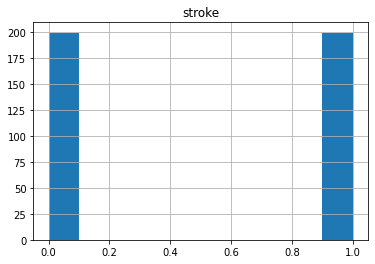

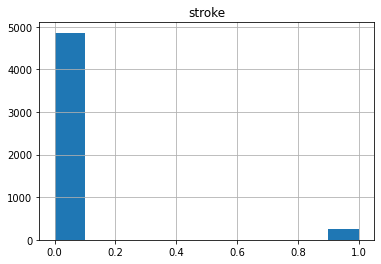

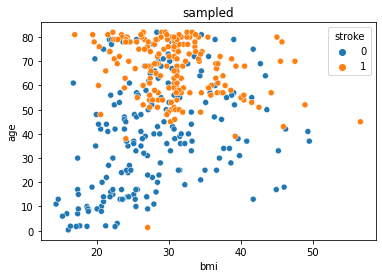

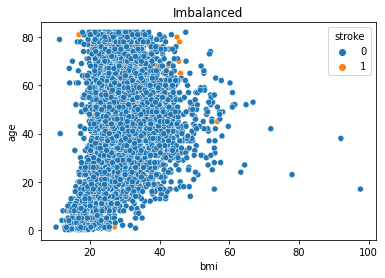

In [90]:
dfsample.hist(column="stroke")
df_cleaned.hist(column="stroke")
plt.show()


sns.scatterplot(data=dfsample, x=Xsample["bmi"], y=Xsample["age"], hue=ysample)
plt.title("sampled")
plt.show()

plt.title("Imbalanced")
sns.scatterplot(data=df_cleaned, x=df_cleaned["bmi"], y=df_cleaned["age"], hue=y)


In [91]:
def evalNBmodels(x_train, x_test, y_train, y_test, features, title, a_score):
  Bernoulli = BernoulliNB()
  Gaussian = GaussianNB()
  Multinomial = MultinomialNB()
  Complement = ComplementNB()


  Bernoulli.fit(x_train[features], y_train)
  Gaussian.fit(x_train[features], y_train)
  Multinomial.fit(x_train[features], y_train)
  Complement.fit(x_train[features], y_train)

  more_models = [BernoulliNB(), GaussianNB(), MultinomialNB(), ComplementNB()]

  scores = [a_score(y_test, Bernoulli.predict(x_test[features])),\
            a_score(y_test, Gaussian.predict(x_test[features])),\
            a_score(y_test, Multinomial.predict(x_test[features])),\
            a_score(y_test, Complement.predict(x_test[features]))]
            
  print(scores)
  
  models = [Bernoulli, Gaussian, Multinomial, Complement]
  names = ["Bernoulli", "Gaussian", "Multinomial", "Complement"]
  max_score = np.max(scores)
  score_idx = np.argmax(scores)


  return(max_score, models[score_idx])

def evalBest(model, feats, x_test, y_test, xtr, ytr, title):


  feats = [['hypertension', 'heart_disease', 'smoking_status', 'bmi', 'age'],\
           ["gender", "hypertension", "heart_disease", "ever_married", "Residence_type"],\
           list(selected_columns),\
           list(x_test.columns)]

  cohorts = ["Medical", "Binary", "Least Correlated", "All Features"]

  print(title)
  print("\n")

  for feat, cohort in zip(feats, cohorts):
    print(cohort)
    model.fit(xtr[feat], ytr)
    print("Accuracy Score: ", model.score(x_test[feat], y_test))
    print("Overall Recall Score: ", (recall_score(y_test, model.predict(x_test[feat]), pos_label=1)+recall_score(y_test, model.predict(x_test[feat]), pos_label=0))/2)
    print("Overall Precision Score: ", (precision_score(y_test, model.predict(x_test[feat]), pos_label=1)+precision_score(y_test, model.predict(x_test[feat]), pos_label=0))/2)
    print("Overall F1 Score: ", (f1_score(y_test, model.predict(x_test[feat]), pos_label=1)+f1_score(y_test, model.predict(x_test[feat]), pos_label=0))/2)
    print("1 Recall Score: ", (recall_score(y_test, model.predict(x_test[feat]), pos_label=1)))
    print("1 Precision Score: ", (precision_score(y_test, model.predict(x_test[feat]), pos_label=1)))
    print("1 F1 Score: ", (f1_score(y_test, model.predict(x_test[feat]), pos_label=1)))
    print("0 Recall Score: ", (recall_score(y_test, model.predict(x_test[feat]), pos_label=0)))
    print("0 Precision Score: ", (precision_score(y_test, model.predict(x_test[feat]), pos_label=0)))
    print("0 F1 Score: ", (f1_score(y_test, model.predict(x_test[feat]), pos_label=0)))
    print("\n")
    print("\n")
  




  







In [92]:
metrics = [f1_score, recall_score]
best_model = []
for metric in metrics:
  print("\n")
  print(metric)
  models = []
  scores = []
  # ALL
  score, mod = evalNBmodels(Xsample, x_test, ysample, y_test, df_cleaned.columns[:-1], "All Features", metric)
  models.append(mod)
  scores.append(score)


  # Binary
  feats = ["gender", "hypertension", "heart_disease", "ever_married", "Residence_type"]

  score, mod = evalNBmodels(Xsample, x_test, ysample, y_test, feats, "Binary Features", metric)
  models.append(mod)
  scores.append(score)

  # Medically significant features
  feats = ['hypertension', 'heart_disease', 'smoking_status', 'bmi', 'age']

  score, mod = evalNBmodels(Xsample, x_test, ysample, y_test, feats, "Most Significant Features", metric)
  models.append(mod)
  scores.append(score)

  # Correlated 
  # https://towardsdatascience.com/feature-selection-correlation-and-p-value-da8921bfb3cf
  corr = X.corr()
  columns = np.full((corr.shape[0],), True, dtype=bool)
  for i in range(corr.shape[0]):
      for j in range(i+1, corr.shape[0]):
          if corr.iloc[i,j] >= .1:
              if columns[j]:
                  columns[j] = False
                  
  selected_columns = Xsample.columns[columns]
  feats = list(selected_columns)
  score, mod = evalNBmodels(Xsample, x_test, ysample, y_test, feats, "Correlated", metric)
  models.append(mod)
  scores.append(score)

  best = np.argmax(scores)
  print("best", models[best])
  best_model.append(models[best])




<function f1_score at 0x7f49656b63b0>
[0.13311148086522462, 0.21468926553672316, 0.1716937354988399, 0.1716937354988399]
[0.13553113553113555, 0.21348314606741572, 0.1529745042492918, 0.1529745042492918]
[0.21052631578947364, 0.2178217821782178, 0.18639798488664988, 0.18639798488664988]
[0.09448818897637795, 0.18543046357615894, 0.14396887159533076, 0.14396887159533076]
best GaussianNB()


<function recall_score at 0x7f49656b67a0>
[0.8, 0.76, 0.74, 0.74]
[0.74, 0.38, 0.54, 0.54]
[0.4, 0.66, 0.74, 0.74]
[0.36, 0.84, 0.74, 0.74]
best GaussianNB()


In [93]:
gnb = GaussianNB()
evalBest(gnb, df_cleaned.columns[:-1], x_test, y_test, Xsample, ysample, "Gaussian")

# bnb = BernoulliNB()
# evalBest(bnb, df_cleaned.columns[:-1], x_test, y_test, "Bernoulli")

# mnb = MultinomialNB()
# evalBest(mnb, df_cleaned.columns[:-1], x_test, y_test, "Multinomial")



Gaussian


Medical
Accuracy Score:  0.7681017612524462
Overall Recall Score:  0.7168312757201647
Overall Precision Score:  0.5541640753095494
Overall F1 Score:  0.5408465602447665
1 Recall Score:  0.66
1 Precision Score:  0.13043478260869565
1 F1 Score:  0.2178217821782178
0 Recall Score:  0.7736625514403292
0 Precision Score:  0.9778933680104032
0 F1 Score:  0.8638713383113154




Binary
Accuracy Score:  0.863013698630137
Overall Recall Score:  0.6339300411522634
Overall Precision Score:  0.556880942393736
Overall F1 Score:  0.5692281753916929
1 Recall Score:  0.38
1 Precision Score:  0.1484375
1 F1 Score:  0.21348314606741572
0 Recall Score:  0.8878600823045267
0 Precision Score:  0.9653243847874721
0 F1 Score:  0.92497320471597




Least Correlated
Accuracy Score:  0.6389432485322897
Overall Recall Score:  0.7343004115226337
Overall Precision Score:  0.5456471456002437
Overall F1 Score:  0.47675042977676596
1 Recall Score:  0.84
1 Precision Score:  0.10421836228287841
1 F1 Score:  0

# **K-Nearest Neighbors**

In [120]:
clean_data_path = "/content/drive/MyDrive/FDS_Project/healthcare-dataset-stroke-data-clean.csv"
df_cleaned = pd.read_csv(clean_data_path)

In [121]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = max(y)
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

In [122]:
# Initial split
features = df_cleaned.drop(['stroke'], axis = 1)
target = df_cleaned['stroke']

feats_train, feats_test, target_train, target_test = train_test_split(features, target, test_size = 0.1, stratify=target, random_state=0)

In [123]:
# KNN Model with no optimization or oversampling

knn = KNeighborsClassifier()
knn.fit(feats_train, target_train.values.ravel())
target_pred = knn.predict(feats_test)
f1 = f1_score(target_test, target_pred)
accuracy = accuracy_score(target_test, target_pred)
precision = precision_score(target_test, target_pred)
recall = recall_score(target_test, target_pred)

print("Best model metrics:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

print(classification_report(target_test, target_pred, zero_division=0))

# Calculate AUC
probs = knn.predict_proba(feats_test)
probs = probs[:,1]
auc = roc_auc_score(target_test,probs)
print(auc)

Best model metrics:
Accuracy:  0.9471624266144814
Precision:  0.0
Recall:  0.0
F1 Score:  0.0
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       486
           1       0.00      0.00      0.00        25

    accuracy                           0.95       511
   macro avg       0.48      0.50      0.49       511
weighted avg       0.90      0.95      0.93       511

0.5893004115226337


In [124]:

# Counts pre-oversampling
print("target_train value counts:")
print(target_train.value_counts())
print("\nfeats_train length")
print(len(feats_train))


target_train value counts:
0    4374
1     224
Name: stroke, dtype: int64

feats_train length
4598


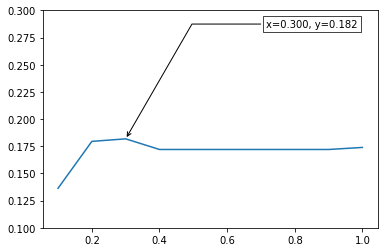

In [125]:
# Optimizing sampling_strategy
sample_size = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
f1_list = []
recall_list = []
rand_num = range(1,100,1)

for weight in sample_size:
    ros = over.RandomOverSampler(sampling_strategy = weight,random_state=42)
    feat_res, target_res = ros.fit_resample(feats_train, target_train)

    features_os = pd.DataFrame(data = feat_res)
    target_os = pd.DataFrame(data = target_res)
    feats_train_os, feats_test_os, target_train_os, target_test_os = \
        train_test_split(features_os, target_os, test_size = 0.1, stratify=target_os, random_state=0)
    knn = KNeighborsClassifier()
    knn.fit(feats_train_os, target_train_os.values.ravel())
    target_pred = knn.predict(feats_test)
    f1 = f1_score(target_test, target_pred)
    recall = recall_score(target_test, target_pred)
    f1_list.append(f1)
    recall_list.append(recall)

x = sample_size
y = f1_list
fig, ax = plt.subplots()
ax.plot(x,y)
annot_max(x,y)
ax.set_ylim(0.1,0.3)
plt.show()


In [126]:

ros = over.RandomOverSampler(sampling_strategy = 0.2,random_state=42)
feat_res, target_res = ros.fit_resample(feats_train, target_train)

features_os = pd.DataFrame(data = feat_res)
target_os = pd.DataFrame(data = target_res)

feats_train_os, feats_test_os, target_train_os, target_test_os = \
    train_test_split(features_os, target_os, test_size = 0.1, stratify=target_os, random_state=0)

print("target_res value counts:")
print(target_res.value_counts())
print("\nfeats_res length")
print(len(feat_res))


target_res value counts:
0    4374
1     874
Name: stroke, dtype: int64

feats_res length
5248


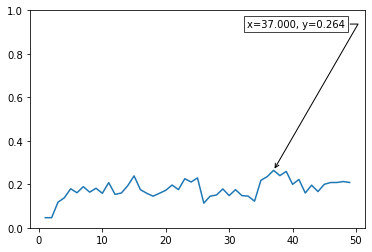

In [127]:
# Hyper-parameter optimization
k_range = range(1,50)
f1_list = []
recall_list = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(feats_train_os, target_train_os.values.ravel())
    target_pred = knn.predict(feats_test)
    f1 = f1_score(target_test, target_pred)
    recall = recall_score(target_test, target_pred)
    f1_list.append(f1)
    recall_list.append(recall)

x = k_range
y = f1_list
fig, ax = plt.subplots()
ax.plot(x,y)
annot_max(x,y)
ax.set_ylim(0.0,1)
plt.show()


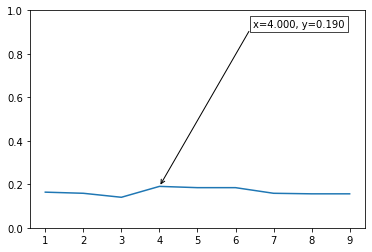

In [128]:
p_range = range(1, 10)
f1_list = []
recall_list = []

for p in p_range:
    knn = KNeighborsClassifier(n_neighbors = 19, p = p)
    knn.fit(feats_train_os, target_train_os.values.ravel())
    target_pred = knn.predict(feats_test)
    f1 = f1_score(target_test, target_pred)
    recall = recall_score(target_test, target_pred)
    f1_list.append(f1)
    recall_list.append(recall)

x = p_range
y = f1_list
fig, ax = plt.subplots()
ax.plot(x,y)
annot_max(x,y)
ax.set_ylim(0.0,1)
plt.show()


In [129]:

knn = KNeighborsClassifier(n_neighbors = 37, p = 2)
knn.fit(feats_train_os, target_train_os.values.ravel())
target_pred = knn.predict(feats_test)
f1 = f1_score(target_test, target_pred)
accuracy = accuracy_score(target_test, target_pred)
precision = precision_score(target_test, target_pred)
recall = recall_score(target_test, target_pred)

print("Best model metrics:")
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

print(classification_report(target_test, target_pred, zero_division=0))

# Calculate AUC
probs = knn.predict_proba(feats_test)
probs = probs[:,1]
auc = roc_auc_score(target_test,probs)
print(auc)

Best model metrics:
Accuracy:  0.923679060665362
Precision:  0.25
Recall:  0.28
F1 Score:  0.2641509433962264
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       486
           1       0.25      0.28      0.26        25

    accuracy                           0.92       511
   macro avg       0.61      0.62      0.61       511
weighted avg       0.93      0.92      0.93       511

0.7909876543209876


# MLP

In [78]:
df = pd.read_csv("/content/drive/MyDrive/FDS_Project/healthcare-dataset-stroke-data-clean.csv")
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,30.702991,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


In [79]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [80]:
X = df.drop(['stroke'], axis = 1).values
y = df['stroke'].values

Xtr, Xts, ytr, yts = train_test_split(X, y, test_size = 0.1, stratify=y, random_state=42)

In [81]:
print(f"Train: {len(Xtr)} \nTest: {len(Xts)}")

Train: 4598 
Test: 511


In [82]:
print(f"Train dist:\n{np.unique(ytr, return_counts=True)[1]}")
#print(f"\nDev dist:\n{ydev.value_counts()}")
print(f"\nTest dist:\n{np.unique(yts, return_counts=True)[1]}")

Train dist:
[4374  224]

Test dist:
[486  25]


In [83]:
print(f"class_1/class_2: {sum(ytr==1)/sum(ytr==0)}")

class_1/class_2: 0.051211705532693184


In [85]:
def get_param_comb(params):
    # get all possible hyperparamter combinations
    comb = []
    for vals in itertools.product(*params.values()):
        comb.append(dict(zip(params, vals)))
    return comb

def get_kfold_scores(res, n=0):
    # the difference of mean and standard error of the AUCs of all folds
    #res_mean = np.mean(res, axis=1)
    #res_stderr = np.std(res, axis=1) / np.sqrt(n)
    #kfold_scores = res_mean - res_stderr
    kfold_scores = np.mean(res, axis=1)
    return kfold_scores
    
def get_best_model(X, y, Xts, yts, kfold, params, model_class):
    # get all possible hyperparamter combinations
    param_comb = get_param_comb(params)
    
    # results
    res_f1 = np.zeros((len(param_comb), 1))
    res_recall = np.zeros((len(param_comb), 1))
    res_auc = np.zeros((len(param_comb), 1))
    cur_best = 0.0
    
    # scaling
    scaler = StandardScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    Xts = scaler.transform(Xts)
    n = None
    
    for comb_idx, comb in tqdm(enumerate(param_comb), total=len(param_comb)):
        # split
        Xtr_fold, ytr_fold = X, y
        Xts_fold, yts_fold = Xts, yts

        # sampling
        #ros = over.RandomOverSampler(random_state=42, sampling_strategy=comb['over_sample_ratios'])
        rus = under.RandomUnderSampler(random_state=42, sampling_strategy=comb["under_sample_ratios"])
        ros = over.SMOTE(random_state=42, sampling_strategy=comb['over_sample_ratios'])
        #print(comb['over_sample_ratios'], comb['under_sample_ratios'])
        try:
            #Xtr, ytr = rus.fit_resample(X, y)
            Xtr_fold_os, ytr_fold_os = ros.fit_resample(Xtr_fold, ytr_fold)
            Xtr_fold_os, ytr_fold_os = rus.fit_resample(Xtr_fold_os, ytr_fold_os)
        except ValueError:
            #print(f"ERROR: over: {comb['over_sample_ratios']}, under: {comb['under_sample_ratios']}")
            continue

        # model
        clf = model_class(hidden_layer_sizes=comb["hidden_layer_sizes"], learning_rate="adaptive", random_state=4, 
                          warm_start=True, early_stopping=True, max_iter=1000, n_iter_no_change=20)
        clf.fit(Xtr_fold_os, ytr_fold_os)

        # prediction
        y_pred = clf.predict(Xts_fold)

        # AUC score
        auc = roc_auc_score(yts_fold, y_pred, multi_class='ovr')
        # F1 score
        f1 = f1_score(yts_fold, y_pred, average="macro", zero_division=0)
        # recall
        recall = recall_score(yts_fold, y_pred, average="macro", zero_division=0)
        if f1 > cur_best:
            print(f"Best model: {comb} with F1-{f1}")
            cur_best = f1

        res_f1[comb_idx] = f1
        res_recall[comb_idx] = recall
        res_auc[comb_idx] = auc
    
    # kfold mean scores
    f1_kfold_scores = get_kfold_scores(res_f1)
    auc_kfold_scores = get_kfold_scores(res_auc)
    recall_kfold_scores = get_kfold_scores(res_recall)
    
    # best model
    f1_opt_idx = np.argmax(f1_kfold_scores)
    auc_opt_idx = np.argmax(auc_kfold_scores)
    recall_opt_idx = np.argmax(recall_kfold_scores)
    
    # best hyperparameter combination
    f1_opt_comb = param_comb[f1_opt_idx]
    auc_opt_comb = param_comb[auc_opt_idx]
    recall_opt_comb = param_comb[recall_opt_idx]
    
    # best score
    f1_best = res_f1[f1_opt_idx]
    auc_best = res_auc[auc_opt_idx]
    recall_best = res_recall[recall_opt_idx]
    
    #print(f"best hyperparameters: {opt_comb}")
    #print(f"best kfold score: {best_kfold_score}")

    d = {
        "f1": f1_opt_comb,
        "auc": auc_opt_comb,
        "recall": recall_opt_comb
    }
    clfs = {}
    for mode, opt_comb in d.items():
        # get best model
        rus = under.RandomUnderSampler(random_state=42, sampling_strategy=opt_comb["under_sample_ratios"])
        ros = over.SMOTE(random_state=42, sampling_strategy=opt_comb['over_sample_ratios'])
        Xtr, ytr = ros.fit_resample(X, y)
        Xtr, ytr = rus.fit_resample(Xtr, ytr)
        
        clf = model_class(hidden_layer_sizes=opt_comb["hidden_layer_sizes"], learning_rate="adaptive", random_state=4, 
                          warm_start=True, early_stopping=True, max_iter=1000, n_iter_no_change=20)
        clf.fit(Xtr, ytr)

        # AUC, F1, Recall
        y_pred = clf.predict(Xts)
        auc = roc_auc_score(yts, y_pred, multi_class='ovr')
        #f1 = f1_score(yts, y_pred, average="macro")
        #recall = recall_score(yts, y_pred, average="macro")
        print(f"Mode: {mode}")
        print(f"AUC: {auc}")
        print(classification_report(yts, y_pred, zero_division=0))
        print("="*20)
        clfs[mode] = clf
    
    return (f1_kfold_scores, auc_kfold_scores, recall_kfold_scores), (f1_opt_comb, auc_opt_comb, recall_opt_comb), clfs

In [86]:
# train model without any hyperparameters

scaler = StandardScaler()
scaler.fit(Xtr)
Xtr_s = scaler.transform(Xtr)
Xts_s = scaler.transform(Xts)

clf = MLPClassifier(learning_rate="adaptive", random_state=4, 
                  warm_start=True, early_stopping=True, max_iter=1000, n_iter_no_change=20)
clf.fit(Xtr_s, ytr)

# prediction
y_pred = clf.predict(Xts_s)

# AUC score
auc = roc_auc_score(yts, y_pred, multi_class='ovr')
# F1 score
f1 = f1_score(yts, y_pred, average="macro")
# recall
recall = recall_score(yts, y_pred, average="macro")

print(f"f1: {f1}, auc: {auc}, recall: {recall}")
print(classification_report(yts, y_pred, zero_division=0))

f1: 0.48746238716148443, auc: 0.5, recall: 0.5
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       486
           1       0.00      0.00      0.00        25

    accuracy                           0.95       511
   macro avg       0.48      0.50      0.49       511
weighted avg       0.90      0.95      0.93       511



In [87]:
params = {
  "hidden_layer_sizes": [(10,10,10), (20,20,20), (30,30,30), (40,40,40), (50), (50,50), (50,50,50), (100), (100, 100), (200)],
  "over_sample_ratios": np.arange(0.0, 0.5, 0.05),
  "under_sample_ratios": np.arange(0.0, 0.5, 0.05),
}
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
scores, combs, clfs = get_best_model(Xtr, ytr, Xts, yts, kfold, params=params, model_class=MLPClassifier)

  2%|▏         | 23/1000 [00:00<00:33, 29.07it/s]

Best model: {'hidden_layer_sizes': (10, 10, 10), 'over_sample_ratios': 0.1, 'under_sample_ratios': 0.1} with F1-0.48746238716148443


  3%|▎         | 26/1000 [00:05<04:47,  3.39it/s]

Best model: {'hidden_layer_sizes': (10, 10, 10), 'over_sample_ratios': 0.1, 'under_sample_ratios': 0.25} with F1-0.608673907947175


  4%|▎         | 35/1000 [00:14<11:22,  1.41it/s]

Best model: {'hidden_layer_sizes': (10, 10, 10), 'over_sample_ratios': 0.15000000000000002, 'under_sample_ratios': 0.2} with F1-0.6555511498810468


 63%|██████▎   | 634/1000 [11:33<04:59,  1.22it/s]

Best model: {'hidden_layer_sizes': (50, 50, 50), 'over_sample_ratios': 0.15000000000000002, 'under_sample_ratios': 0.15000000000000002} with F1-0.67201540436457


100%|██████████| 1000/1000 [21:42<00:00,  1.30s/it]


Mode: f1
AUC: 0.6338271604938271
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       486
           1       0.54      0.28      0.37        25

    accuracy                           0.95       511
   macro avg       0.75      0.63      0.67       511
weighted avg       0.94      0.95      0.95       511

Mode: auc
AUC: 0.7582716049382717
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       486
           1       0.21      0.64      0.32        25

    accuracy                           0.86       511
   macro avg       0.59      0.76      0.62       511
weighted avg       0.94      0.86      0.90       511

Mode: recall
AUC: 0.7582716049382717
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       486
           1       0.21      0.64      0.32        25

    accuracy                           0.86       511
   macro avg       0.59 

In [88]:
combs

({'hidden_layer_sizes': (50, 50, 50),
  'over_sample_ratios': 0.15000000000000002,
  'under_sample_ratios': 0.15000000000000002},
 {'hidden_layer_sizes': (100, 100),
  'over_sample_ratios': 0.1,
  'under_sample_ratios': 0.45},
 {'hidden_layer_sizes': (100, 100),
  'over_sample_ratios': 0.1,
  'under_sample_ratios': 0.45})

# **Single Class Classifiers and SVM on Complete and Medical Dataset**

In [130]:
df = pd.read_csv('/content/drive/MyDrive/FDS_Project/healthcare-dataset-stroke-data-clean.csv')

In [131]:
x = df.drop(['stroke'], axis=1)

# medical sets contain features: hypertension, heart_disease, smoking_status, bmi, age
x_medical = df.drop(['stroke','gender','ever_married','Residence_type','avg_glucose_level','work_type'], axis=1)

In [132]:
y = df['stroke']

In [133]:
tsne = TSNE(init='pca',learning_rate='auto',random_state=42)

In [134]:
x_vis = tsne.fit_transform(x)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [135]:
x_medical_vis = tsne.fit_transform(x_medical)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [136]:
def visualize_data(val,y):
  sns.scatterplot(val[:,0], val[:,1], hue = y, palette = sns.hls_palette(len(y.unique())), legend = 'auto')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


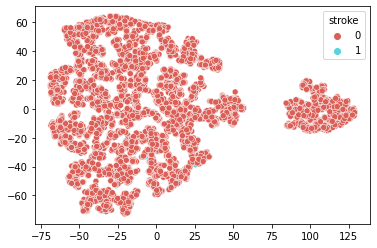

In [137]:
visualize_data(x_vis,y)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


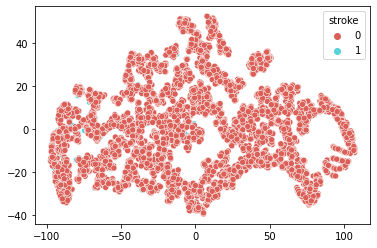

In [138]:
visualize_data(x_medical_vis,y)

In [139]:
minmax_scaler = MinMaxScaler()

In [140]:
x_train_all, x_test_all, y_train_all, y_test_all = train_test_split(x, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

In [141]:
x_train_all = minmax_scaler.fit_transform(x_train_all)
x_test_all = minmax_scaler.fit_transform(x_test_all)

In [142]:
x_train_medical, x_test_medical, y_train_medical, y_test_medical = train_test_split(x_medical, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

In [143]:
x_train_medical = minmax_scaler.fit_transform(x_train_medical)
x_test_medical = minmax_scaler.fit_transform(x_test_medical)

In [144]:
def metrics(y_true, y_hat, label, pos_label, precision_0=None, recall_0=None, f1_0=None, precision_1=None, recall_1=None, f1_1=None):
  if label == 'Overall':
    print(f'Overall:\nRecall: {round((recall_0+recall_1)/2, 3)}\tPrecision: {round((precision_0+precision_1)/2, 3)}\tF1 Score: {round((f1_0+f1_1)/2, 3)}\n')
    # print(f'Overall Recall: {round((recall_0+recall_1)/2, 3)}')
    # print(f'Overall F1 Score: {round((f1_0+f1_1)/2, 3)}')
  else:
    # print(f'{label} Accuracy: {round(accuracy_score(y_true, y_hat), 3)}\n')
    if label == 'Test':
      precision = round(precision_score(y_true, y_hat, pos_label=pos_label), 3)
      recall = round(recall_score(y_true, y_hat, pos_label=pos_label), 3)
      f1 = round(f1_score(y_true, y_hat, pos_label=pos_label), 3)
      print(f'For Class {pos_label}:\nRecall: {recall}\tPrecision: {precision}\tF1 Score: {f1}\n')
      # print(f'Recall(for class {pos_label}): {recall}\n')
      # print(f'F1 Score (on test set, for class {pos_label}): {f1}\n')
      return precision, recall, f1
    else:
      if label is not None:
        print(f'For {label}:\nConfusion Matrix:\n{confusion_matrix(y_true, y_hat)}\tAccuracy: {round(accuracy_score(y_true, y_hat), 3)}\n')
      else:
        print(f'Confusion Matrix:\n{confusion_matrix(y_true, y_hat)}\tAccuracy: {round(accuracy_score(y_true, y_hat), 3)}\n')
  return None, None, None

def format_y(y):
  y_true = y.copy()
  y_true[y_true == 1] = -1
  y_true[y_true == 0] = 1
  return y_true

# **Single Class Models**

# **Single Class SVM**

In [145]:
def single_svm(x_train, x_test, y_test):
  y_true = format_y(y_test)

  single_svc = OneClassSVM()
  single_svc.fit(x_train)
  y_hat = single_svc.predict(x_test)
  precision_0, recall_0, f1_0 = metrics(y_true, y_hat, 'Test', 1)
  precision_1, recall_1, f1_1 = metrics(y_true, y_hat, 'Test', -1)
  _, _, _ = metrics(y_true, y_hat, None, None) # conf
  _, _, _ = metrics(None, None, 'Overall', None, precision_0=precision_0, recall_0=recall_0, f1_0=f1_0, precision_1=precision_1, recall_1=recall_1, f1_1=f1_1)


**Complete data**

In [146]:
single_svm(x_train_all[y_train_all == 0], x_test_all, y_test_all)

For Class 1:
Recall: 0.418	Precision: 0.971	F1 Score: 0.584

For Class -1:
Recall: 0.76	Precision: 0.063	F1 Score: 0.116

Confusion Matrix:
[[ 19   6]
 [283 203]]	Accuracy: 0.434

Overall:
Recall: 0.589	Precision: 0.517	F1 Score: 0.35



**Medically sound features**

In [147]:
single_svm(x_train_medical[y_train_medical == 0], x_test_medical, y_test_medical)

For Class 1:
Recall: 0.344	Precision: 0.982	F1 Score: 0.509

For Class -1:
Recall: 0.88	Precision: 0.065	F1 Score: 0.12

Confusion Matrix:
[[ 22   3]
 [319 167]]	Accuracy: 0.37

Overall:
Recall: 0.612	Precision: 0.524	F1 Score: 0.314



# **Isolation Forest**

In [148]:
def isolation_forest(x_train, x_test, y_test):
  y_true = format_y(y_test)

  iso_forest = IsolationForest()
  iso_forest.fit(x_train)
  y_hat = iso_forest.predict(x_test)
  precision_0, recall_0, f1_0 = metrics(y_true, y_hat, 'Test', 1)
  precision_1, recall_1, f1_1 = metrics(y_true, y_hat, 'Test', -1)
  _, _, _ = metrics(y_true, y_hat, None, None) # conf
  _, _, _ = metrics(None, None, 'Overall', None, precision_0=precision_0, recall_0=recall_0, f1_0=f1_0, precision_1=precision_1, recall_1=recall_1, f1_1=f1_1)

**Complete data**

In [149]:
isolation_forest(x_train_all[y_train_all == 0], x_test_all, y_test_all)

For Class 1:
Recall: 0.407	Precision: 0.961	F1 Score: 0.572

For Class -1:
Recall: 0.68	Precision: 0.056	F1 Score: 0.103

Confusion Matrix:
[[ 17   8]
 [288 198]]	Accuracy: 0.421

Overall:
Recall: 0.544	Precision: 0.508	F1 Score: 0.337



**Medically sound features**

In [150]:
isolation_forest(x_train_medical[y_train_medical == 0], x_test_medical, y_test_medical)

For Class 1:
Recall: 0.494	Precision: 0.976	F1 Score: 0.656

For Class -1:
Recall: 0.76	Precision: 0.072	F1 Score: 0.131

Confusion Matrix:
[[ 19   6]
 [246 240]]	Accuracy: 0.507

Overall:
Recall: 0.627	Precision: 0.524	F1 Score: 0.394



# **Binary Classification**

In [151]:
undersampler = RandomUnderSampler(random_state=42)

In [152]:
oversampler = SMOTE(random_state=42)

In [153]:
x_undersampled_all, y_undersampled_all = undersampler.fit_resample(x_train_all,y_train_all)

In [154]:
x_undersampled_medical, y_undersampled_medical = undersampler.fit_resample(x_train_medical,y_train_medical)

In [155]:
x_oversampled_all, y_oversampled_all = oversampler.fit_resample(x_train_all,y_train_all)

In [156]:
x_oversampled_medical, y_oversampled_medical = oversampler.fit_resample(x_train_medical,y_train_medical)

# **SVM**

In [157]:
def svm(x_train, x_test, y_train, y_test):
  svc = SVC(C=0.001)
  svc.fit(x_train, y_train)
  y_hat_train = svc.predict(x_train)
  y_hat_test = svc.predict(x_test)
  _, _, _ = metrics(y_train, y_hat_train, 'Train', 1)
  precision_0, recall_0, f1_0 = metrics(y_test, y_hat_test, 'Test', 0)
  precision_1, recall_1, f1_1 = metrics(y_test, y_hat_test, 'Test', 1)
  _, _, _ = metrics(y_test, y_hat_test, None, None) # conf
  _, _, _ = metrics(None, None, 'Overall', None, precision_0=precision_0, recall_0=recall_0, f1_0=f1_0, precision_1=precision_1, recall_1=recall_1, f1_1=f1_1)

# **SVM with Undersampling**

**Complete data**

In [158]:
svm(x_undersampled_all, x_test_all, y_undersampled_all, y_test_all)

For Train:
Confusion Matrix:
[[ 87 137]
 [  7 217]]	Accuracy: 0.679

For Class 0:
Recall: 0.335	Precision: 0.994	F1 Score: 0.502

For Class 1:
Recall: 0.96	Precision: 0.069	F1 Score: 0.129

Confusion Matrix:
[[163 323]
 [  1  24]]	Accuracy: 0.366

Overall:
Recall: 0.648	Precision: 0.532	F1 Score: 0.316




**Medically sound features**

In [159]:
svm(x_undersampled_medical, x_test_medical, y_undersampled_medical, y_test_medical)

For Train:
Confusion Matrix:
[[141  83]
 [ 15 209]]	Accuracy: 0.781

For Class 0:
Recall: 0.599	Precision: 0.98	F1 Score: 0.743

For Class 1:
Recall: 0.76	Precision: 0.089	F1 Score: 0.159

Confusion Matrix:
[[291 195]
 [  6  19]]	Accuracy: 0.607

Overall:
Recall: 0.68	Precision: 0.534	F1 Score: 0.451



# **SVM with Oversampling**

**Complete data**

In [160]:
svm(x_oversampled_all, x_test_all, y_oversampled_all, y_test_all)

For Train:
Confusion Matrix:
[[1957 2417]
 [ 243 4131]]	Accuracy: 0.696

For Class 0:
Recall: 0.451	Precision: 0.986	F1 Score: 0.619

For Class 1:
Recall: 0.88	Precision: 0.076	F1 Score: 0.14

Confusion Matrix:
[[219 267]
 [  3  22]]	Accuracy: 0.472

Overall:
Recall: 0.666	Precision: 0.531	F1 Score: 0.38



**Medically sound features**

In [161]:
svm(x_oversampled_medical, x_test_medical, y_oversampled_medical, y_test_medical)

For Train:
Confusion Matrix:
[[3063 1311]
 [ 757 3617]]	Accuracy: 0.764

For Class 0:
Recall: 0.7	Precision: 0.983	F1 Score: 0.817

For Class 1:
Recall: 0.76	Precision: 0.115	F1 Score: 0.2

Confusion Matrix:
[[340 146]
 [  6  19]]	Accuracy: 0.703

Overall:
Recall: 0.73	Precision: 0.549	F1 Score: 0.508

